In [9]:
import pandas as pd
import numpy as np
import requests as rq
import tweepy as tp
import json
import datetime
from tweepy import OAuthHandler
import matplotlib.pyplot as plt

In [10]:
df_arch = pd.read_csv('twitter-archive-enhanced.csv')
df_arch['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [11]:
response = rq.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')

with open('image_predictions' , 'wb') as file:
    file.write(response.content)

df_image = pd.read_csv('image_predictions' , sep = '\t')
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
# consumer_key, consumer_secret = 
# access_token, access_token_secret = 

# auth = tp.OAuthHandler(consumer_key, consumer_secret)
# auth.set_access_token(access_token, access_token_secret)

# api = tp.API(auth)
# df_API = {}
# for tweet in df_pr['tweet_id']:
#     tweet = api.get_status(tweet)
#     df_API = {'retweet' : tweet.retweet_count,
#     'favorite' : tweet.favorite_count}

In [14]:
tweets = []
for line in open('tweet-json', 'r'):
    tweets.append(json.loads(line))
df_api = pd.DataFrame(tweets)
df_api.rename(columns = {'id' : 'tweet_id'} , inplace = True)
df_api

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,False,False,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,Mon Nov 16 00:24:50 +0000 2015,666049248165822465,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,False,False,en,NaN,NaN,NaN,NaN
2350,Mon Nov 16 00:04:52 +0000 2015,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,False,False,en,NaN,NaN,NaN,NaN
2351,Sun Nov 15 23:21:54 +0000 2015,666033412701032449,666033412701032449,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,False,False,en,NaN,NaN,NaN,NaN
2352,Sun Nov 15 23:05:30 +0000 2015,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,False,False,en,NaN,NaN,NaN,NaN


In [15]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [16]:
df_arch['retweeted_status_user_id'].dropna()

19      4.196984e+09
32      1.960740e+07
36      4.196984e+09
68      4.196984e+09
73      4.196984e+09
            ...     
1023    4.196984e+09
1043    4.196984e+09
1242    7.832140e+05
2259    4.296832e+09
2260    4.296832e+09
Name: retweeted_status_user_id, Length: 181, dtype: float64

In [20]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2354 non-null   object 
 1   tweet_id                       2354 non-null   int64  
 2   id_str                         2354 non-null   object 
 3   full_text                      2354 non-null   object 
 4   truncated                      2354 non-null   bool   
 5   display_text_range             2354 non-null   object 
 6   entities                       2354 non-null   object 
 7   extended_entities              2073 non-null   object 
 8   source                         2354 non-null   object 
 9   in_reply_to_status_id          78 non-null     float64
 10  in_reply_to_status_id_str      78 non-null     object 
 11  in_reply_to_user_id            78 non-null     float64
 12  in_reply_to_user_id_str        78 non-null     o

In [21]:
x = list(df_api[df_api['in_reply_to_status_id'].isnull()]['tweet_id'])
y = list(df_api[df_api['retweeted_status'].isnull()]['tweet_id'])
z = list(df_api[df_api['quoted_status'].isnull()]['tweet_id'])
len(y)

2175

# assessing

In [76]:
df_api

,created_at,tweet_id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,Tue Aug 01 16:23:56 +0000 2017,892420643555336193,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,False,False,en,NaN,NaN,NaN,NaN
1,Tue Aug 01 00:17:27 +0000 2017,892177421306343426,892177421306343426,This is Tilly. She's just checking pup on you....,False,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,33819,False,False,False,False,en,NaN,NaN,NaN,NaN
2,Mon Jul 31 00:18:03 +0000 2017,891815181378084864,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,False,"[0, 121]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891815175371796480, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,25461,False,False,False,False,en,NaN,NaN,NaN,NaN
3,Sun Jul 30 15:58:51 +0000 2017,891689557279858688,891689557279858688,This is Darla. She commenced a snooze mid meal...,False,"[0, 79]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 891689552724799489, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,42908,False,False,False,False,en,NaN,NaN,NaN,NaN
4,Sat Jul 29 16:00:24 +0000 2017,891327558926688256,891327558926688256,This is Franklin. He would like you to stop ca...,False,"[0, 138]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 891327551943041024, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,41048,False,False,False,False,en,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,Mon Nov 16 00:24:50 +0000 2015,666049248165822465,666049248165822465,Here we have a 1949 1st generation vulpix. Enj...,False,"[0, 120]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666049244999131136, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,111,False,False,False,False,en,NaN,NaN,NaN,NaN
2350,Mon Nov 16 00:04:52 +0000 2015,666044226329800704,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,False,"[0, 137]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666044217047650304, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,311,False,False,False,False,en,NaN,NaN,NaN,NaN
2351,Sun Nov 15 23:21:54 +0000 2015,666033412701032449,666033412701032449,Here is a very happy pup. Big fan of well-main...,False,"[0, 130]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666033409081393153, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,128,False,False,False,False,en,NaN,NaN,NaN,NaN
2352,Sun Nov 15 23:05:30 +0000 2015,666029285002620928,666029285002620928,This is a western brown Mitsubishi terrier. Up...,False,"[0, 139]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 666029276303482880, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,132,False,False,False,False,en,NaN,NaN,NaN,NaN


In [77]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2354 non-null   object 
 1   tweet_id                       2354 non-null   int64  
 2   id_str                         2354 non-null   object 
 3   full_text                      2354 non-null   object 
 4   truncated                      2354 non-null   bool   
 5   display_text_range             2354 non-null   object 
 6   entities                       2354 non-null   object 
 7   extended_entities              2073 non-null   object 
 8   source                         2354 non-null   object 
 9   in_reply_to_status_id          78 non-null     float64
 10  in_reply_to_status_id_str      78 non-null     object 
 11  in_reply_to_user_id            78 non-null     float64
 12  in_reply_to_user_id_str        78 non-null     o

In [79]:
df_api.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweet_count,favorite_count,quoted_status_id
count,2.354000e+03,7.800000e+01,7.800000e+01,2354.000000,2354.000000,2.900000e+01
mean,7.426978e+17,7.455079e+17,2.014171e+16,3164.797366,8080.968564,8.162686e+17
std,6.852812e+16,7.582492e+16,1.252797e+17,5284.770364,11814.771334,6.164161e+16
min,6.660209e+17,6.658147e+17,1.185634e+07,0.000000,0.000000,6.721083e+17
25%,6.783975e+17,6.757419e+17,3.086374e+08,624.500000,1415.000000,7.888183e+17
50%,7.194596e+17,7.038708e+17,4.196984e+09,1473.500000,3603.500000,8.340867e+17
75%,7.993058e+17,8.257804e+17,4.196984e+09,3652.000000,10122.250000,8.664587e+17
max,8.924206e+17,8.862664e+17,8.405479e+17,79515.000000,132810.000000,8.860534e+17


In [92]:
df_api.value_counts

<bound method DataFrame.value_counts of                           created_at            tweet_id              id_str  \
0     Tue Aug 01 16:23:56 +0000 2017  892420643555336193  892420643555336193   
1     Tue Aug 01 00:17:27 +0000 2017  892177421306343426  892177421306343426   
2     Mon Jul 31 00:18:03 +0000 2017  891815181378084864  891815181378084864   
3     Sun Jul 30 15:58:51 +0000 2017  891689557279858688  891689557279858688   
4     Sat Jul 29 16:00:24 +0000 2017  891327558926688256  891327558926688256   
...                              ...                 ...                 ...   
2349  Mon Nov 16 00:24:50 +0000 2015  666049248165822465  666049248165822465   
2350  Mon Nov 16 00:04:52 +0000 2015  666044226329800704  666044226329800704   
2351  Sun Nov 15 23:21:54 +0000 2015  666033412701032449  666033412701032449   
2352  Sun Nov 15 23:05:30 +0000 2015  666029285002620928  666029285002620928   
2353  Sun Nov 15 22:32:08 +0000 2015  666020888022790149  666020888022790149   


In [81]:
df_arch

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [82]:
df_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [83]:
df_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [90]:
df_arch.value_counts()

Series([], dtype: int64)

In [84]:
df_image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [85]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [86]:
df_image.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [87]:
df_image.value_counts()

tweet_id            jpg_url                                                                                  img_num  p1                      p1_conf   p1_dog  p2                p2_conf   p2_dog  p3                   p3_conf   p3_dog
892420643555336193  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg                                          1        orange                  0.097049  False   bagel             0.085851  False   banana               0.076110  False     1
685321586178670592  https://pbs.twimg.com/media/CYLAWFMWMAEcRzb.jpg                                          1        Boston_bull             0.972483  True    French_bulldog    0.025469  True    boxer                0.000458  True      1
683834909291606017  https://pbs.twimg.com/ext_tw_video_thumb/683834825250320385/pu/img/yZdrqMlyky4KGOu6.jpg  1        Maltese_dog             0.738449  True    toy_poodle        0.102992  True    Samoyed              0.023247  True      1
683849932751646720  https://pbs.twimg.com/media/C



## Quality

### data from tweeter archive
- the data is combination of tweets , replys , quoted tweets and retweets and we only need the original tweets.
- missed values in archive data are being represented by 'None' .
- in image predection tables the names of the columns aren't descriptive
- the existence of unnecessary columns ('in_reply_to_status_id' , 'in_reply_to_user_id' , 'in_reply_to_user_id_str' , 'in_reply_to_status_id_str' , 'in_reply_to_screen_name' , 'retweeted_status' , 'geo' , 'quoted_status_id' , 'quoted_status' , 'quoted_status_id_str' , 'coordinates' , 'contributors' , 'place')
- the names of the dogs are sometimes get wrong (a, the, ...etc)
- (timestamp) column has data type object
- after creating a column for the dog stage, its elements data type has to be category
- 12 tweets have more than one dog, multiple names and multiple dog stages
- 501 of the expanded_urls in df_arch contains more than one url, 473 out of them are duplicated url.
- 13 rating numerator values are extremly high.

### image_prediction 
- (P1, P2, P3) columns better be of data type category

## tidiness

- there is no column for the dog type
- the archive table has to be divided into two data sets: one for the tweet information and the other for the dogs information
- some additional columns has to be removed (the whole df_api table except for the id, favorite_count, retweet_count)

In [22]:
df_arch_c = df_arch.copy()
df_image_c = df_image.copy()

df_api_c = df_api.copy()

# clean

In [23]:
df_api_c = df_api_c[df_api_c['in_reply_to_status_id'].isnull()]
df_api_c = df_api_c[df_api_c['retweeted_status'].isnull()]
df_api_c = df_api_c[df_api_c['quoted_status_id'].isnull()]
df_api_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2353
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   created_at                     2069 non-null   object 
 1   tweet_id                       2069 non-null   int64  
 2   id_str                         2069 non-null   object 
 3   full_text                      2069 non-null   object 
 4   truncated                      2069 non-null   bool   
 5   display_text_range             2069 non-null   object 
 6   entities                       2069 non-null   object 
 7   extended_entities              1971 non-null   object 
 8   source                         2069 non-null   object 
 9   in_reply_to_status_id          0 non-null      float64
 10  in_reply_to_status_id_str      0 non-null      object 
 11  in_reply_to_user_id            0 non-null      float64
 12  in_reply_to_user_id_str        0 non-null      o

# define
# the data is combination of tweets , replys , quoted tweets and retweets and we only need the original tweets.

# missed values in archive data are being represented by 'None' .



# code

In [24]:
df_arch_c = df_arch[df_arch['tweet_id'].isin(x) & df_arch['tweet_id'].isin(y) & df_arch['tweet_id'].isin(z)]
# df_arch_c = df_arch[df_arch['tweet_id'].isin(y)]
df_arch_c.replace('None' , np.nan , inplace = True)
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2069 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2069 non-null   object 
 4   source                      2069 non-null   object 
 5   text                        2069 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      float64
 9   expanded_urls               2066 non-null   object 
 10  rating_numerator            2069 non-null   int64  
 11  rating_denominator          2069 non-null   int64  
 12  name                        1493 non-null   object 
 13  doggo                       80 no

C:\Users\Gomaa\anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [25]:
df_image_c = df_image_c[df_image['tweet_id'].isin(x) & df_image['tweet_id'].isin(y) & df_image['tweet_id'].isin(z)]

# test

In [26]:
df_image_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1971 non-null   int64  
 1   jpg_url   1971 non-null   object 
 2   img_num   1971 non-null   int64  
 3   p1        1971 non-null   object 
 4   p1_conf   1971 non-null   float64
 5   p1_dog    1971 non-null   bool   
 6   p2        1971 non-null   object 
 7   p2_conf   1971 non-null   float64
 8   p2_dog    1971 non-null   bool   
 9   p3        1971 non-null   object 
 10  p3_conf   1971 non-null   float64
 11  p3_dog    1971 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 159.8+ KB


In [27]:
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2069 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2069 non-null   object 
 4   source                      2069 non-null   object 
 5   text                        2069 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      float64
 9   expanded_urls               2066 non-null   object 
 10  rating_numerator            2069 non-null   int64  
 11  rating_denominator          2069 non-null   int64  
 12  name                        1493 non-null   object 
 13  doggo                       80 no

# define
# the existence of unnecessary columns ('in_reply_to_status_id' , 'in_reply_to_user_id' , 'in_reply_to_user_id_str' , 'in_reply_to_status_id_str' , 'in_reply_to_screen_name' , 'retweeted_status' , 'geo' , 'quoted_status_id' , 'quoted_status' , 'quoted_status_id_str' , 'coordinates' , 'contributors' , 'place')

# code

In [28]:
df_api_c.drop(['in_reply_to_status_id' , 'in_reply_to_user_id' , 'in_reply_to_user_id_str' , 'in_reply_to_status_id_str' , 'in_reply_to_screen_name' , 'retweeted_status' , 'geo' , 'quoted_status_id' , 'quoted_status' , 'quoted_status_id_str' , 'coordinates' , 'contributors' , 'place'] , axis = 1 , inplace = True)  
df_arch_c.drop(['in_reply_to_status_id' , 'in_reply_to_user_id' , 'retweeted_status_id' , 'retweeted_status_user_id' , 'retweeted_status_timestamp'] , axis = 1 , inplace = True)



C:\Users\Gomaa\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# test

In [29]:
df_api_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2353
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   created_at                     2069 non-null   object
 1   tweet_id                       2069 non-null   int64 
 2   id_str                         2069 non-null   object
 3   full_text                      2069 non-null   object
 4   truncated                      2069 non-null   bool  
 5   display_text_range             2069 non-null   object
 6   entities                       2069 non-null   object
 7   extended_entities              1971 non-null   object
 8   source                         2069 non-null   object
 9   user                           2069 non-null   object
 10  is_quote_status                2069 non-null   bool  
 11  retweet_count                  2069 non-null   int64 
 12  favorite_count                 2069 non-null   int64 
 13  fav

In [30]:
df_api_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2353
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   created_at                     2069 non-null   object
 1   tweet_id                       2069 non-null   int64 
 2   id_str                         2069 non-null   object
 3   full_text                      2069 non-null   object
 4   truncated                      2069 non-null   bool  
 5   display_text_range             2069 non-null   object
 6   entities                       2069 non-null   object
 7   extended_entities              1971 non-null   object
 8   source                         2069 non-null   object
 9   user                           2069 non-null   object
 10  is_quote_status                2069 non-null   bool  
 11  retweet_count                  2069 non-null   int64 
 12  favorite_count                 2069 non-null   int64 
 13  fav

In [31]:
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2069 non-null   int64 
 1   timestamp           2069 non-null   object
 2   source              2069 non-null   object
 3   text                2069 non-null   object
 4   expanded_urls       2066 non-null   object
 5   rating_numerator    2069 non-null   int64 
 6   rating_denominator  2069 non-null   int64 
 7   name                1493 non-null   object
 8   doggo               80 non-null     object
 9   floofer             10 non-null     object
 10  pupper              228 non-null    object
 11  puppo               24 non-null     object
dtypes: int64(3), object(9)
memory usage: 210.1+ KB


# define
# (timestamp) column has data type object

# code

In [32]:
df_arch_c['timestamp'] = pd.to_datetime(df_arch_c['timestamp'])

<ipython-input-32-388bb52dfcbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arch_c['timestamp'] = pd.to_datetime(df_arch_c['timestamp'])


# test

In [33]:
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2069 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2069 non-null   int64              
 1   timestamp           2069 non-null   datetime64[ns, UTC]
 2   source              2069 non-null   object             
 3   text                2069 non-null   object             
 4   expanded_urls       2066 non-null   object             
 5   rating_numerator    2069 non-null   int64              
 6   rating_denominator  2069 non-null   int64              
 7   name                1493 non-null   object             
 8   doggo               80 non-null     object             
 9   floofer             10 non-null     object             
 10  pupper              228 non-null    object             
 11  puppo               24 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(3

# define
# in image predection tables the columns (p1 , p2 , p3) are better be of the type category.


# code

In [34]:
df_image_c['p1'] = df_image_c['p1'].astype('category')
df_image_c['p2'] = df_image_c['p2'].astype('category')
df_image_c['p3'] = df_image_c['p3'].astype('category')

# test

In [35]:
df_image_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   tweet_id  1971 non-null   int64   
 1   jpg_url   1971 non-null   object  
 2   img_num   1971 non-null   int64   
 3   p1        1971 non-null   category
 4   p1_conf   1971 non-null   float64 
 5   p1_dog    1971 non-null   bool    
 6   p2        1971 non-null   category
 7   p2_conf   1971 non-null   float64 
 8   p2_dog    1971 non-null   bool    
 9   p3        1971 non-null   category
 10  p3_conf   1971 non-null   float64 
 11  p3_dog    1971 non-null   bool    
dtypes: bool(3), category(3), float64(3), int64(2), object(1)
memory usage: 184.3+ KB


# define
# there is no column for the dog type

# code

In [36]:
df_arch_c['dog_stage'] = df_arch_c[df_arch_c.columns[8:]].apply(lambda x: ','.join(x.dropna().astype('str')) , axis = 1)

<ipython-input-36-d658a4e54287>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arch_c['dog_stage'] = df_arch_c[df_arch_c.columns[8:]].apply(lambda x: ','.join(x.dropna().astype('str')) , axis = 1)


In [37]:
df_arch_c.drop(df_arch_c[df_arch_c['dog_stage'].str.contains(',')].index, axis=0, inplace=True)


# test

In [38]:
df_arch_c['dog_stage'].value_counts()


           1738
pupper      219
doggo        69
puppo        23
floofer       9
Name: dog_stage, dtype: int64

# define
# after creating a column for the dog stage, its elements data type has to be category

# code

In [39]:
df_arch_c['dog_stage'] = df_arch_c['dog_stage'].astype('category')

<ipython-input-39-9b78fb37798a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arch_c['dog_stage'] = df_arch_c['dog_stage'].astype('category')


# test

In [40]:
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2355
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2058 non-null   int64              
 1   timestamp           2058 non-null   datetime64[ns, UTC]
 2   source              2058 non-null   object             
 3   text                2058 non-null   object             
 4   expanded_urls       2055 non-null   object             
 5   rating_numerator    2058 non-null   int64              
 6   rating_denominator  2058 non-null   int64              
 7   name                1488 non-null   object             
 8   doggo               69 non-null     object             
 9   floofer             9 non-null      object             
 10  pupper              219 non-null    object             
 11  puppo               23 non-null     object             
 12  dog_stage           2058 non-null 

# define
# in image predection tables the names of the columns aren't descriptive


# code

In [41]:
df_image_c.rename(inplace = True , columns = {'p1':'dog_type(1)','p2':'dog_type(2)','p3':'dog_type(3)','p1_conf':'p1_confidence','p2_conf':'p2_confidence','p3_conf':'p3_confidence','p1_dog':'p1_isdog?','p2_dog':'p2_isdog?','p3_dog':'p3_isdog?'})

# test

In [42]:
df_image_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   tweet_id       1971 non-null   int64   
 1   jpg_url        1971 non-null   object  
 2   img_num        1971 non-null   int64   
 3   dog_type(1)    1971 non-null   category
 4   p1_confidence  1971 non-null   float64 
 5   p1_isdog?      1971 non-null   bool    
 6   dog_type(2)    1971 non-null   category
 7   p2_confidence  1971 non-null   float64 
 8   p2_isdog?      1971 non-null   bool    
 9   dog_type(3)    1971 non-null   category
 10  p3_confidence  1971 non-null   float64 
 11  p3_isdog?      1971 non-null   bool    
dtypes: bool(3), category(3), float64(3), int64(2), object(1)
memory usage: 184.3+ KB


In [43]:
# unnecessary columns after being merged into one column 
df_arch_c.drop(['doggo','floofer','pupper','puppo','rating_denominator'] , axis = 1 , inplace = True)
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   tweet_id          2058 non-null   int64              
 1   timestamp         2058 non-null   datetime64[ns, UTC]
 2   source            2058 non-null   object             
 3   text              2058 non-null   object             
 4   expanded_urls     2055 non-null   object             
 5   rating_numerator  2058 non-null   int64              
 6   name              1488 non-null   object             
 7   dog_stage         2058 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 130.8+ KB


In [44]:
df_arch_c[df_arch_c['expanded_urls'].isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,name,dog_stage
375,828361771580813312,2017-02-05 21:56:51+00:00,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,12,NaN,
707,785515384317313025,2016-10-10 16:20:36+00:00,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,10,NaN,
1445,696518437233913856,2016-02-08 02:18:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,10,NaN,pupper


# define
# 501 of the expanded_urls in df_arch contains more than one url, 473 out of them are duplicated url.

# code

In [45]:
urls_list = []
for x in df_arch_c['expanded_urls']:
    y = len(str(x).split(','))
    if y > 1:
        urls_list.append(x)

len(urls_list)

501

In [46]:
urls_list_d = []
for x in list(df_arch_c['expanded_urls']):
    if len(str(x).split(',')) > 1:
        if x.split(',')[0] == x.split(',')[1]:
            urls_list_d.append(x[:x.find(',')])
        else:
            urls_list_d.append(x.split(',')[-1])
    else:
        urls_list_d.append(x)

df_arch_c['expanded_urls'] = urls_list_d

df_arch_c['expanded_urls']

<ipython-input-46-c0e41c876c60>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arch_c['expanded_urls'] = urls_list_d


0       https://twitter.com/dog_rates/status/892420643...
1       https://twitter.com/dog_rates/status/892177421...
2       https://twitter.com/dog_rates/status/891815181...
3       https://twitter.com/dog_rates/status/891689557...
4       https://twitter.com/dog_rates/status/891327558...
                              ...                        
2351    https://twitter.com/dog_rates/status/666049248...
2352    https://twitter.com/dog_rates/status/666044226...
2353    https://twitter.com/dog_rates/status/666033412...
2354    https://twitter.com/dog_rates/status/666029285...
2355    https://twitter.com/dog_rates/status/666020888...
Name: expanded_urls, Length: 2058, dtype: object

# test

In [47]:
df_arch_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2058 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   tweet_id          2058 non-null   int64              
 1   timestamp         2058 non-null   datetime64[ns, UTC]
 2   source            2058 non-null   object             
 3   text              2058 non-null   object             
 4   expanded_urls     2055 non-null   object             
 5   rating_numerator  2058 non-null   int64              
 6   name              1488 non-null   object             
 7   dog_stage         2058 non-null   category           
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 130.8+ KB


In [48]:
urls_list = []
for x in df_arch_c['expanded_urls']:
    y = len(str(x).split(','))
    if y > 1:
        urls_list.append(x)
len(urls_list)

0

# define
# some additional columns has to be removed (the whole df_api table except for the id, favorite_count, retweet_count)

# code

In [49]:
df_api_ed = pd.DataFrame({'tweet_id' :df_api_c['tweet_id'],
'favorite_count' : df_api_c['favorite_count'],
'retweet_count' : df_api_c['retweet_count']})

df_api_ed

,tweet_id,favorite_count,retweet_count
0,892420643555336193,39467,8853
1,892177421306343426,33819,6514
2,891815181378084864,25461,4328
3,891689557279858688,42908,8964
4,891327558926688256,41048,9774
...,...,...,...
2349,666049248165822465,111,41
2350,666044226329800704,311,147
2351,666033412701032449,128,47
2352,666029285002620928,132,48


# define
# Divide the data into two : tweet info, dog info

# code

In [50]:
df_arch_tweet_info = df_arch_c[['tweet_id' , 'timestamp' , 'source' , 'text' , 'expanded_urls']]
df_arch_tweet_info

,tweet_id,timestamp,source,text,expanded_urls
0,892420643555336193,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...
...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...
2352,666044226329800704,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...
2353,666033412701032449,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...
2354,666029285002620928,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...


In [51]:
df_arch_dog_info = df_arch_c[['tweet_id' , 'name' , 'dog_stage' , 'rating_numerator']]
df_arch_dog_info

,tweet_id,name,dog_stage,rating_numerator
0,892420643555336193,Phineas,,13
1,892177421306343426,Tilly,,13
2,891815181378084864,Archie,,12
3,891689557279858688,Darla,,13
4,891327558926688256,Franklin,,12
...,...,...,...,...
2351,666049248165822465,NaN,,5
2352,666044226329800704,a,,6
2353,666033412701032449,a,,9
2354,666029285002620928,a,,7


In [68]:
df_dogs = pd.merge(df_arch_dog_info, df_image_c, on='tweet_id')
df_dogs1 = pd.merge(df_dogs, df_api_ed, on='tweet_id')

In [70]:
df_dogs1

,tweet_id,name,dog_stage,rating_numerator,jpg_url,img_num,dog_type(1),p1_confidence,p1_isdog?,dog_type(2),p2_confidence,p2_isdog?,dog_type(3),p3_confidence,p3_isdog?,favorite_count,retweet_count
0,892420643555336193,Phineas,,13,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,39467,8853
1,892177421306343426,Tilly,,13,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,33819,6514
2,891815181378084864,Archie,,12,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,25461,4328
3,891689557279858688,Darla,,13,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,42908,8964
4,891327558926688256,Franklin,,12,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,41048,9774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,666049248165822465,NaN,,5,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,111,41
1957,666044226329800704,a,,6,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True,311,147
1958,666033412701032449,a,,9,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True,128,47
1959,666029285002620928,a,,7,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True,132,48


In [93]:
df_dogs2 = pd.merge(df_dogs1, df_arch_tweet_info, on='tweet_id')
df_dogs2

,tweet_id,name,dog_stage,rating_numerator,jpg_url,img_num,dog_type(1),p1_confidence,p1_isdog?,dog_type(2),...,p2_isdog?,dog_type(3),p3_confidence,p3_isdog?,favorite_count,retweet_count,timestamp,source,text,expanded_urls
0,892420643555336193,Phineas,,13,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,...,False,banana,0.076110,False,39467,8853,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...
1,892177421306343426,Tilly,,13,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,...,True,papillon,0.068957,True,33819,6514,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...
2,891815181378084864,Archie,,12,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,...,True,kelpie,0.031379,True,25461,4328,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...
3,891689557279858688,Darla,,13,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,...,True,spatula,0.040836,False,42908,8964,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...
4,891327558926688256,Franklin,,12,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,...,True,German_short-haired_pointer,0.175219,True,41048,9774,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1956,666049248165822465,NaN,,5,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,...,True,Doberman,0.154629,True,111,41,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...
1957,666044226329800704,a,,6,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,...,True,miniature_pinscher,0.222752,True,311,147,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...
1958,666033412701032449,a,,9,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,...,True,bloodhound,0.116197,True,128,47,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...
1959,666029285002620928,a,,7,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,...,True,Rhodesian_ridgeback,0.072010,True,132,48,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...


# define
# 13 rating numerator values are extremly high.


# code

In [59]:
def correct(x):
    if x > 50:
        x = int(x / 100)
    return x
df_arch_dog_info['rating_numerator'] = df_arch_dog_info['rating_numerator'].apply(correct)   

<ipython-input-59-a2a7c9824a3c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_arch_dog_info['rating_numerator'] = df_arch_dog_info['rating_numerator'].apply(correct)


# test

In [60]:
df_arch_dog_info['rating_numerator'].value_counts()

12    474
10    433
11    411
13    270
9     153
8      98
7      52
14     34
5      33
6      32
3      19
4      17
2      10
1       8
0       7
45      1
24      1
26      1
27      1
50      1
17      1
44      1
Name: rating_numerator, dtype: int64

# storing the data

In [94]:
df_dogs2.to_csv('twitter_archive_master' , index = False)

# visualization

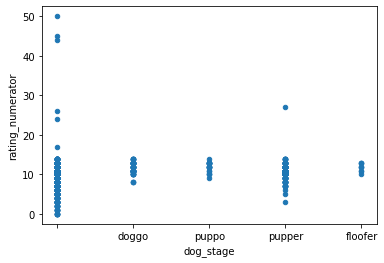

In [75]:
df_arch_dog_info.plot(x = 'dog_stage' , y = 'rating_numerator' , kind = 'scatter');

In [111]:
x = df_dogs1['dog_type(1)']
y = df_dogs1['favorite_count']



<BarContainer object of 1961 artists>

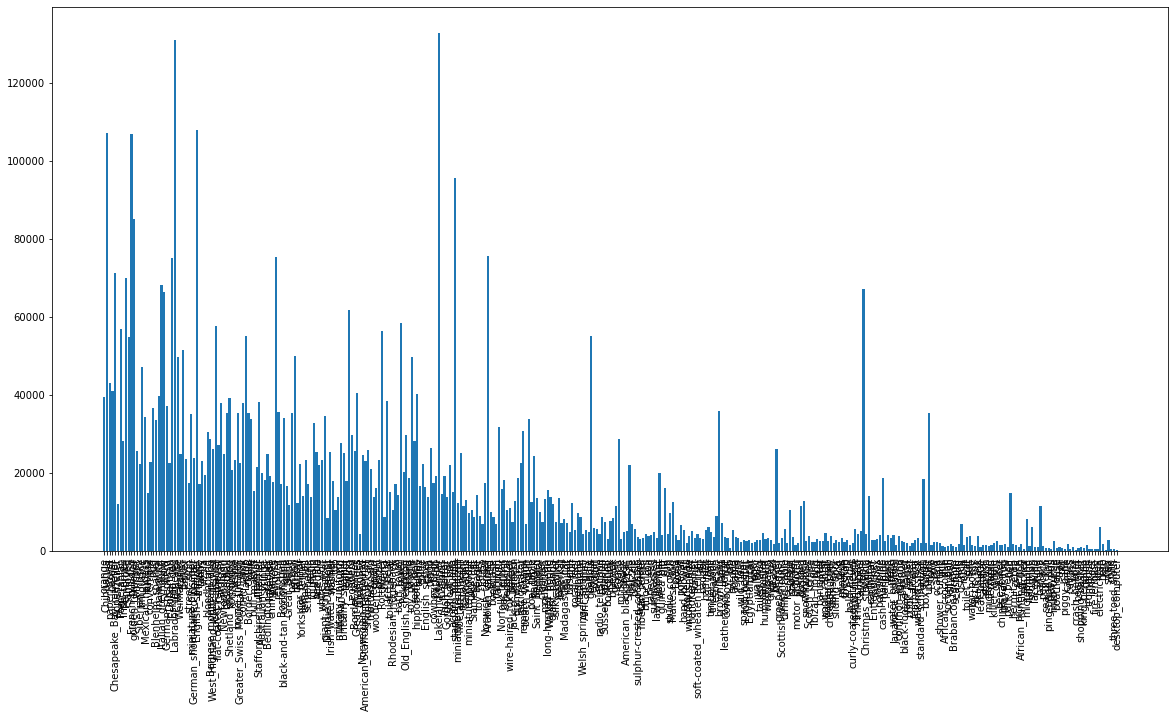

In [121]:

plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
plt.bar(x,y)



- it seems from the first plot that there is no relation between the ratings and the dog stage

- it seems from the second plot that there are a strong relation between the dog type and how prefered the dog is.

### the first ten types

In [127]:
df_dogs1.sort_values('favorite_count')['dog_type(1)'].head(10)

1944             English_setter
1924     curly-coated_retriever
1942           desktop_computer
1956         miniature_pinscher
1932    black-and-tan_coonhound
1951           miniature_poodle
1947                        pug
1958            German_shepherd
1930                toy_terrier
1925                  Chihuahua
Name: dog_type(1), dtype: category
Categories (373, object): ['Afghan_hound', 'African_crocodile', 'African_grey', 'African_hunting_dog', ..., 'wood_rabbit', 'wooden_spoon', 'wool', 'zebra']